## RUN ADAPTIVE SAMPLING in a modified version of the Schutte potential (Schutte et al. JCP 2011).

Instead of running new simulations in each epoch, parts from a reference long trajectory are employed. We test different scoring functions; namely, 'counts', 'populations', 'flux imbalance' and 'non-detailed balance'.

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### Analysis of the potential

In [3]:
h5file = "data/schutte_x05_num1e+08_dt0.0005.h5"
f = h5py.File(h5file, 'r')
data0 = np.array(f['data'])
f.close()
X = data0

In [4]:
X0, X1 = X[:,0], X[:,1]
X.shape, X0.shape, X0[:5]

((50001, 2),
 (50001,),
 array([0.        , 1.00000005, 2.00000009, 3.00000014, 4.00000019]))

Text(0, 0.5, 'PMF')

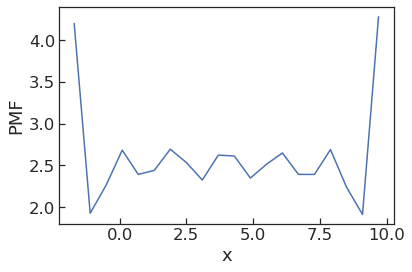

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(X[:,1], bins=np.linspace(-2,10,21), density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist),label="x")
ax.set_xlabel('x')
ax.set_ylabel('PMF') #($k_BT$)

In [6]:
assigned_trj = list(np.digitize(X[:,1],bins=bin_edges))

Text(0, 0.5, 'x')

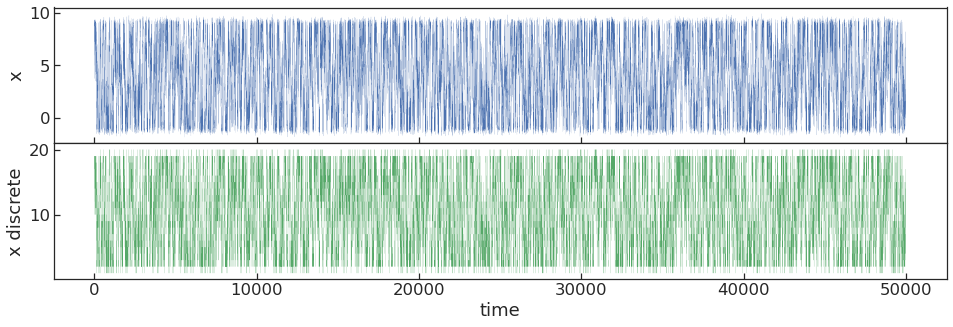

In [7]:
fig,ax=plt.subplots(2,1, figsize=(16,5), sharex=False)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(X[:,0],X[:,1], lw=0.1)
ax[1].step(range(len(assigned_trj)),assigned_trj, color="g", lw=0.1)
ax[-1].set_xlabel('time')
ax[-1].set_ylabel('x discrete')
ax[0].set_ylabel('x')

MasterMSM: Obtain the reference MSM for later comparisons

In [8]:
from mastermsm.trajectory import traj
distraj = traj.TimeSeries(distraj=assigned_trj, dt=1)
distraj.find_keys()
distraj.keys.sort()

In [9]:
from mastermsm.msm import msm
msm_1D=msm.SuperMSM([distraj], sym=False)

     # states: 20


In [10]:
for lt in [1, 2, 5, 10, 20]: #, 50, 100
    msm_1D.do_msm(lt)
    msm_1D.msms[lt].do_trans(evecs=True)
    msm_1D.msms[lt].boots()

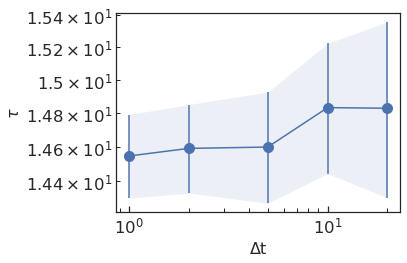

In [11]:
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[0], msm_1D.msms[x].tau_std[0]] \
               for x in sorted(msm_1D.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.fill_between(tau_vs_lagt[:,0],tau_vs_lagt[:,1]+tau_vs_lagt[:,2], \
                tau_vs_lagt[:,1]-tau_vs_lagt[:,2], alpha=0.1)
ax.set_xlabel(r'$\Delta$t', fontsize=16)
ax.set_ylabel(r'$\tau$', fontsize=16)
#ax.set_xlim(0.8,120)
#ax.set_ylim(2e2,500)
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

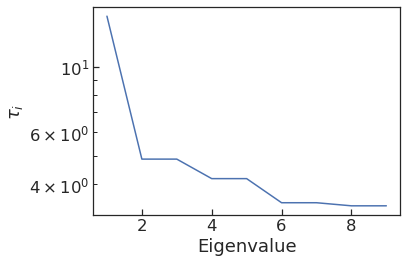

In [12]:
fig, ax = plt.subplots()
ax.plot(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT)
#ax.errorbar(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT, fmt='o-', \
#            yerr= msm_1D.msms[lt].tau_std, ms=10)
#ax.fill_between(range(1,len(msm_1D.msms[1].tauT)+1), \
#        np.array(msm_1D.msms[lt].tauT)+np.array(msm_1D.msms[lt].tau_std), \
#        np.array(msm_1D.msms[lt].tauT)-np.array(msm_1D.msms[lt].tau_std))
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$')
ax.set_yscale('log')
plt.tight_layout()

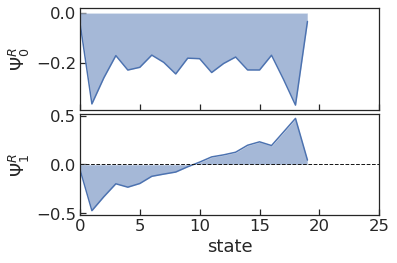

In [13]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
#ax[0].set_ylim(0,0.43)

ax[1].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)
ax[1].set_xlim(0,25)

ax[1].set_xlabel("state")
ax[0].set_ylabel("$\Psi^R_0$")
ax[1].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

Create long trajectory file from which use parts in an artifitial adaptive sampling run

In [14]:
# since dt=1, time column is ommited
h5file = "data/schutte_long.h5"
with h5py.File(h5file, "w") as hf:
    hf.create_dataset("data", data=assigned_trj)

AdaptiveMasterMSM: Test different scoring functions. You MUST create a directory called 'trajs' to run the adaptive_sampling function

In [15]:
type(assigned_trj),len(assigned_trj),assigned_trj[:5]

(list, 50001, [12, 13, 19, 19, 19])

In [16]:
from adaptivemastermsm import controller
from adaptivemastermsm.analyzer import analyzer

Run with overall $4*8*15=480$ steps. Remind that no discretization is done in build_msm inside adaptive_sampling function, since the trajectory in h5file is already discretized.
When printing data below, remind first '# states:' line refers to the reference MSM, so real adaptive sampling from artifitial trajectories starts with second '# states'

In [17]:
conc = controller.Controller(trajfiles=[h5file])
conc.adaptive_sampling(4, 4, sym=False, rate_mat=False, \
        scoring='counts', n_epochs=8, not_run=True, nsteps=15)

     # states: 20
MSM done
sum probabilities: 1.0000000000000002 20 20
Runs for new epoch: [ 0  0 19  5]
Building entry for microstate 0
Building entry for microstate 19
Building entry for microstate 5
not_run info: 0 29287 0
not_run info: 0 12281 0
not_run info: 0 44880 19
not_run info: 0 45978 5
     # states: 15
MSM done
sum probabilities: 1.0 8 8
Runs for new epoch: [6 7 4 7]
Building entry for microstate 6
Building entry for microstate 7
Building entry for microstate 4
not_run info: 1 12 6
not_run info: 1 14 7
not_run info: 1 14 4
not_run info: 1 14 7
     # states: 17
MSM done
sum probabilities: 1.0 8 8
Runs for new epoch: [3 6 6 6]
Building entry for microstate 3
Building entry for microstate 6
not_run info: 2 13 3
not_run info: 2 12 6
not_run info: 2 12 6
not_run info: 2 12 6
     # states: 17
MSM done
sum probabilities: 1.0 8 8
Runs for new epoch: [7 6 6 0]
Building entry for microstate 7
Building entry for microstate 6
Building entry for microstate 0
not_run info: 3 14 7
not_

In [18]:
conc.anal.MSM.keys.sort(), msm_1D.keys.sort()
compare = np.column_stack((conc.anal.MSM.keys[:10],msm_1D.keys[:10]))
compare

array([[ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6,  6],
       [ 8,  7],
       [ 9,  8],
       [10,  9],
       [11, 10]])

In [19]:
conp = controller.Controller(trajfiles=[h5file])
conp.adaptive_sampling(4, 4, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=8, not_run=True, nsteps=15)

     # states: 20
MSM done
sum probabilities: 1.0 20 20
Runs for new epoch: [ 0 11  9  5]
Building entry for microstate 0
Building entry for microstate 11
Building entry for microstate 9
Building entry for microstate 5
not_run info: 0 7076 0
not_run info: 0 43110 11
not_run info: 0 15874 9
not_run info: 0 11572 5
     # states: 17
MSM done
sum probabilities: 1.0 8 8
Runs for new epoch: [3 3 3 7]
Building entry for microstate 3
Building entry for microstate 7
not_run info: 1 5 3
not_run info: 1 5 3
not_run info: 1 5 3
not_run info: 1 14 7
     # states: 18
MSM done
sum probabilities: 1.0 12 12
Runs for new epoch: [0 4 4 8]
Building entry for microstate 0
Building entry for microstate 4
Building entry for microstate 8
not_run info: 2 0 0
not_run info: 2 8 4
not_run info: 2 8 4
not_run info: 2 13 8
     # states: 18
MSM done
sum probabilities: 1.0000000000000002 12 12
Runs for new epoch: [5 1 8 8]
Building entry for microstate 5
Building entry for microstate 1
Building entry for microstat

In [20]:
conf = controller.Controller(trajfiles=[h5file])
conf.adaptive_sampling(4, 4, sym=False, rate_mat=False, \
        scoring='flux', n_epochs=8, not_run=True, nsteps=15)

     # states: 20
MSM done
sum probabilities: 0.9999999999999999 20 20
Runs for new epoch: [ 4  6  6 11]
Building entry for microstate 4
Building entry for microstate 6
Building entry for microstate 11
not_run info: 0 5569 4
not_run info: 0 24351 6
not_run info: 0 8097 6
not_run info: 0 14532 11
     # states: 15
MSM done
sum probabilities: 0.9999999999999998 6 6
Runs for new epoch: [5 5 4 5]
Building entry for microstate 5
Building entry for microstate 4
not_run info: 1 0 5
not_run info: 1 9 5
not_run info: 1 0 4
not_run info: 1 5 5
     # states: 19
MSM done
sum probabilities: 1.0 9 9
Runs for new epoch: [8 6 1 6]
Building entry for microstate 8
Building entry for microstate 6
Building entry for microstate 1
not_run info: 2 3 8
not_run info: 2 1 6
not_run info: 2 12 1
not_run info: 2 1 6
     # states: 19
MSM done
sum probabilities: 1.0 9 9
Runs for new epoch: [6 6 6 1]
Building entry for microstate 6
Building entry for microstate 1
not_run info: 3 1 6
not_run info: 3 1 6
not_run inf

In [21]:
condb = controller.Controller(trajfiles=[h5file])
condb.adaptive_sampling(4, 4, sym=False, rate_mat=False, \
                scoring='non_detailed_balance', n_epochs=8, \
                not_run=True, nsteps=15)

     # states: 20
MSM done
20 20
sum probabilities: 1.0 20 20
Runs for new epoch: [10 19  4 18]
Building entry for microstate 10
Building entry for microstate 19
Building entry for microstate 4
Building entry for microstate 18
not_run info: 0 12727 10
not_run info: 0 27430 19
not_run info: 0 18145 4
not_run info: 0 597 18
     # states: 15
MSM done
11 11
sum probabilities: 1.0 11 11
Runs for new epoch: [ 3  2  7 10]
Building entry for microstate 3
Building entry for microstate 2
Building entry for microstate 7
Building entry for microstate 10
not_run info: 1 2 3
not_run info: 1 7 2
not_run info: 1 3 7
not_run info: 1 6 10
     # states: 16
MSM done
14 14
sum probabilities: 1.0 14 14
Runs for new epoch: [ 8  2  4 12]
Building entry for microstate 8
Building entry for microstate 2
Building entry for microstate 4
Building entry for microstate 12
not_run info: 2 7 8
not_run info: 2 11 2
not_run info: 2 8 4
not_run info: 2 0 12
     # states: 17
MSM done
15 15
sum probabilities: 1.0 15 15
R

COMPARE slowest relaxation times and found keys

In [22]:
msm_1D.msms[5].tauT[0:2], conc.anal.MSM.tauT[0:2], \
conp.anal.MSM.tauT[0:2],conf.anal.MSM.tauT[0:2],condb.anal.MSM.tauT[0:2]

([14.598675356179728, 3.4541569175684805],
 [99.00685557284166, 4.488576537276021],
 [6.217270556534524, 4.77596680740675],
 [6.674819823830636, 2.373866572347771],
 [17.325818529496352, 4.407607828669249])

In [23]:
len(msm_1D.msms[10].keys),len(conc.anal.MSM.keys), \
len(conp.anal.MSM.keys),len(conf.anal.MSM.keys),len(condb.anal.MSM.keys)

(20, 19, 18, 19, 17)

COMPARE eigenvectors from different MSMs

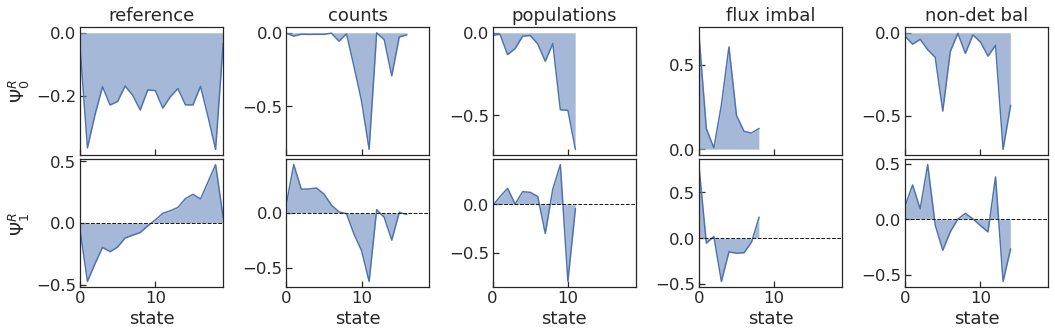

In [35]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=False, figsize=(15,5))
ax[0,0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
ax[0,0].set_title('reference')
ax[1,0].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1,0].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)
# counts
ax[0,1].plot(-conc.anal.MSM.rvecsT[:,0])
ax[0,1].fill_between(range(len(conc.anal.MSM.rvecsT[:,0])), \
                   -conc.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,1].set_title('counts')
ax[1,1].plot(conc.anal.MSM.rvecsT[:,1])
ax[1,1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,1].fill_between(range(len(conc.anal.MSM.rvecsT[:,1])), \
                   conc.anal.MSM.rvecsT[:,1], 0, alpha=0.5)
# populations
ax[0,2].plot(-conp.anal.MSM.rvecsT[:,0])
ax[0,2].fill_between(range(len(conp.anal.MSM.rvecsT[:,0])), \
                   -conp.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,2].set_title('populations')
ax[1,2].plot(conp.anal.MSM.rvecsT[:,1])
ax[1,2].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,2].fill_between(range(len(conp.anal.MSM.rvecsT[:,1])), \
                   conp.anal.MSM.rvecsT[:,1], 0, alpha=0.5)
# flux
ax[0,3].plot(-conf.anal.MSM.rvecsT[:,0])
ax[0,3].fill_between(range(len(conf.anal.MSM.rvecsT[:,0])), \
                   -conf.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,3].set_title('flux imbal')
ax[1,3].plot(conf.anal.MSM.rvecsT[:,1])
ax[1,3].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,3].fill_between(range(len(conf.anal.MSM.rvecsT[:,1])), \
                   conf.anal.MSM.rvecsT[:,1], 0, alpha=0.5)
# non-detailed balance
ax[0,4].plot(-condb.anal.MSM.rvecsT[:,0])
ax[0,4].fill_between(range(len(condb.anal.MSM.rvecsT[:,0])), \
                   -condb.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,4].set_title('non-det bal')
ax[1,4].plot(condb.anal.MSM.rvecsT[:,1])
ax[1,4].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,4].fill_between(range(len(condb.anal.MSM.rvecsT[:,1])), \
                   condb.anal.MSM.rvecsT[:,1], 0, alpha=0.5)
# labels
ax[1,0].set_xlim(0,19)
ax[1,0].set_xlabel("state"), ax[1,1].set_xlabel("state"), ax[1,2].set_xlabel("state"), ax[1,3].set_xlabel("state"), ax[1,4].set_xlabel("state")
ax[0,0].set_ylabel("$\Psi^R_0$")
ax[1,0].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

### END HERE !!!